<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/GWDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.6 MB/s eta 0:00:00
    

**PROBLEM 1**

In [2]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

--2023-03-06 15:42:35--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  17.3MB/s    in 3.9s    

2023-03-06 15:42:40 (14.1 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2023-03-06 15:42:40--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  18.3MB/s    in 4.2s    

20

In [21]:
#Import the usefull libraries
%matplotlib inline
import pylab
from pycbc.filter import highpass,matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
import numpy as np
from pycbc import types
from pycbc.waveform import get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.psd
from pycbc.psd import interpolate


Part 1- Importing the data

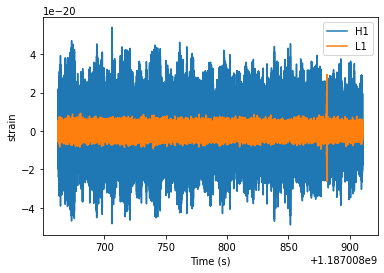

In [11]:
#Then run the following command to load the strain data. 

merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
   # We'll download the data and select 256 seconds that includes the event time
   ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                   '{}:LOSC-STRAIN'.format(ifo),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)
  
   # Read the detector data and remove low frequency content
   strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
 
   # Remove time corrupted by the high pass filter
   strain[ifo] = strain[ifo].crop(4, 4)
  
   # Also create a frequency domain version of the data
   stilde[ifo] = strain[ifo].to_frequencyseries()
 
 
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


Part 2- Signal to Noise ration

In [26]:
#To determine the signal to noise ration, we first need to determine the power spectral density

psds = {}
for ifo in ['L1', 'H1']:


    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2) #how much overlapping of the segments
    psds[ifo]  = pycbc.psd.welch(strain[ifo],#power spectral density
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

'\n    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)\n    pylab.xlim(20, 1024)\n    pylab.ylim(1e-47, 1e-42)\npylab.legend()\n'

In [37]:
#Now we need to create our template K(t)
m1,m2=np.arange(1, 3,0.10 ),np.arange(1, 3,0.10 ) #creating the mass so that  m1=m2
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
ifo = 'H1'
Snr_list = []
for m in m1:
  hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)
  hp.resize(len(strain[ifo]))
  template = hp.cyclic_time_shift(hp.start_time)
  snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)
  snr_H1 = snr.crop(4 + 4, 4)


  Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

#repeating the procedure for the second detector
ifo = 'L1'
Snr_list = []
for m in m1:
  hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)
  hp.resize(len(strain[ifo]))
  template = hp.cyclic_time_shift(hp.start_time)
    
  snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0) 
  snr_H1 = snr.crop(4 + 4, 4)


  Snr_list.append(max(abs(snr_H1)))
  snrs[ifo] = Snr_list 


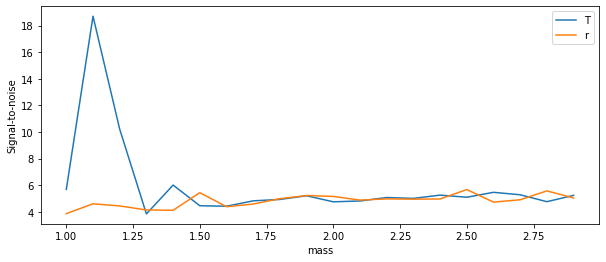

In [38]:
#plotting the histogram of the snr
pylab.figure(figsize=[10, 4])
pylab.plot(m1, snrs['H1'], label= 'H1')
pylab.plot(m1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()
#Note: send email about The fact that the second one does not have a signficant STR

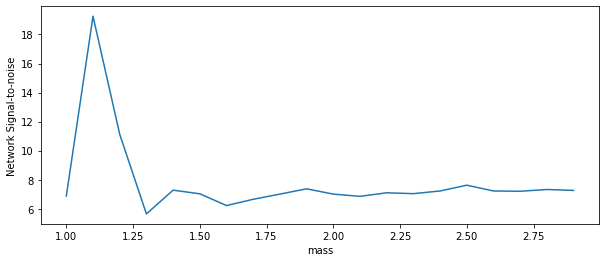

We found the best Mass1=Mass2 was 1.01 solar masses (detector frame)


In [41]:
nsnr =np.sqrt((np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2))#combining the two SNR
ii = np.where(nsnr == max(nsnr))#getting the maximum of the snr
pylab.figure(figsize=[10, 4])
pylab.plot(m1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

In [73]:
#Now I need to recreate my template using the mass that gives the minimum signal-to-noise ratio
# which I found in the previous part. 
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=1.10,
                     mass2=1.10,
                     delta_t=conditioned.delta_t,
                     f_lower=15)

hp.resize(len(conditioned))
template = hp .cyclic_time_shift(hp.start_time)

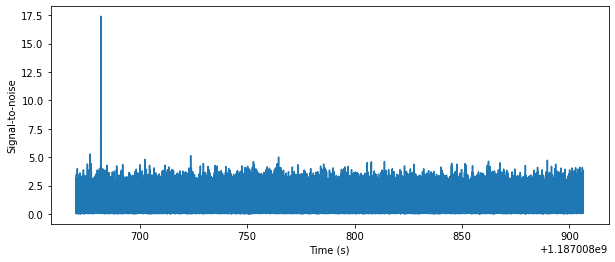

We found a signal at 1187008681.967383s with SNR 17.400042172965897


In [83]:
#Now I can fit the new template to the data, to see when the SNR peak happens
ifo = 'L1'                            
                           
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [84]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

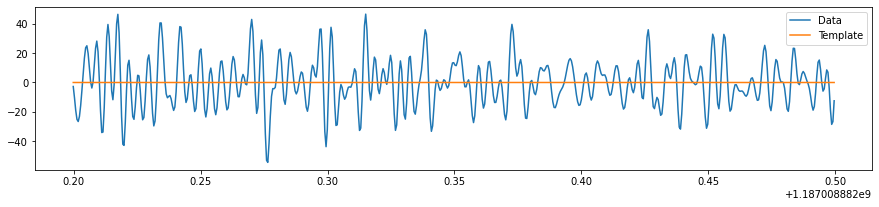

In [85]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

Part 3

In [98]:
#Since we will need to do it quite a few time, it may be useful to greate a function to get the template
def getTemplate(m,sample_rate,f_low):
  hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=1.0/sample_rate,
                     f_lower=f_low)
  return hp, hc #for this task, I don't need the other parameter, so I am not returning it

In [115]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
mass=10
f_low=30
sample_rate=4096
hp, hc = getTemplate(mass,sample_rate,f_low) #creating the first wave form
mass_range = np.arange(5, 15,0.2 )#They are not many, but in this way I can speed up a bit the process
h_to_compare=[]#array to store the wave form that I have to compare with the other
for m in mass_range:
  sp,sc =getTemplate(m,sample_rate,f_low)
  h_to_compare.append(sp)

#Resizing all the waveforms so that they all have te same size
tlen=max(len(hp),len(h_to_compare[0]))
hp.resize(tlen)
for i in h_to_compare:
  i.resize(tlen)
#Now I can compare them
m_values=[]
for h in h_to_compare:
  delta_f=1.0/h.duration
  flen=tlen//2 +1
  psd=aLIGOZeroDetHighPower(flen, delta_f,f_low)
  m,i=match(hp,h,psd=psd,low_frequency_cutoff=f_low)
  m_values.append(m)

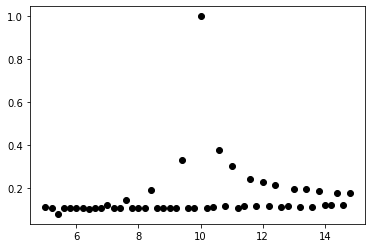

In [116]:
#Now I can plot the graph
pylab.plot(mass_range, m_values, 'o', color='black');


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**PROBLEM 2**

In [10]:
#Problem 2
#first download the data from the assignament 

'''
Loading the data and converting the data type into time series
'''
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
d = types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data = d